# Week 3 Lab: Population genetics (How tall should I be?)


## Part 1
**Due: Monday 4/22/19 11:59pm**

**Partner: ** (optional. You must both turn in the assignment.)

Skills covered: genotype data, principle components analysis, ancestry analysis

Your friend is interested in learning more about her family history, and so sends a saliva sample off to 23andMe for genotyping. You receive a set of SNP genotypes back, and would like to use those to predict the ancestry of your friend.

We can get some insights into the ancestry of an unknown genome sample by comparing it to SNP genotypes of a *reference panel* of samples for which we know their ancestry. We can think of this as a clustering problem: if I cluster a genome with genomes from across the globe, what cluster does it fall in?

Clustering by SNP genotypes turns into a high-dimensional problem, because we can be dealing with millions of SNPs and thousands or more individuals. Principle components analysis (PCA) is a widely used method for helping make sense out of big multi-dimensional datasets like this one. We'll use PCA to see where our example genome falls relative to a panel of several thousand reference control samples, originally sequenced by the [1000 Genomes Project](http://www.internationalgenome.org/).

Today, we'll first gain some intuition about principle component analysis (PCA) and then spend some time getting more familiar with population genetics datasets (mainly VCF files), analysis tools (`bcftools`), and terminology. Then we'll perform ancestry analysis using PCA. In Thursday's lab, we'll use the same dataset to peform a genome-wide association study for height!

**<font color="red">Note</a>**: you will not be responsible for knowing any of the math behind PCA, but you should instead try to get an intuition for what PCA is doing. You should all go through part 1. Part 2 is completely optional. We will also post some extra technical slides with more details for anyone that is interested.

## 1. Intro to PCA

PCA is a commonly used method to reduce the "dimensionality" of a dataset. This comes up in a wide range of bioinformatics applications:

* Preprocessing step to filter out outlier samples
* Data exploration
* Determining ancestry of an individual (the topic of part 1 of the lab!)
* Clustering tumor samples based on expression profiles

Below we'll first get some intution into how PCA works, then we'll go through a small example of using PCA for clustering and outlier detection.

Biology is full of "high-dimensional" data. In our population genetics applications this week, our "dimensions" are the genetic variants (SNPs). For most population genetics applications, we may have several million SNP genotypes per sample. In gene expression applications (next week), our "dimensions" might be genes.

In both cases, the goal of PCA is to find a reduced representation by finding linear combinations of dimensions (in our example, SNPs) that explain the majority of variation in our data.

Let's start by walking through a simple example: you do a survey of your classmates to record their height and weight. The cell below generates this dataset for you and puts it into a pandas data frame (ok ok this is simulated data, but pretend we collected it!)

In [1]:
%pylab inline
# Simulate some random "weight" vs. "height" data.
import numpy as np
import pandas as pd

rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T

height = X[:,0]+65
weight = X[:,1]+120

data = pd.DataFrame({"height": height, "weight": weight})

# You can use `data.head()` to see the columns of the data frame.
# Recall `data["height"]` and `data["weight"]` will access those two columns:
data.head()

Populating the interactive namespace from numpy and matplotlib


,height,weight
0,64.374698,119.829936
1,65.960695,120.590901
2,64.401457,119.597407
3,62.771941,119.467423
4,64.538570,119.501133


Now let's create a scatter plot of this data:

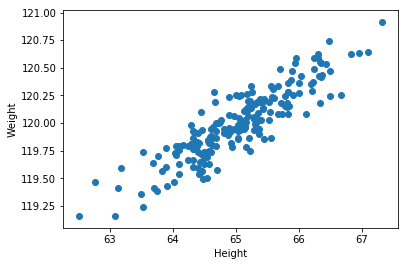

In [2]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data["height"], data["weight"]);
ax.set_xlabel("Height")
ax.set_ylabel("Weight");

**Question 1 (1 pt):** If you had to draw one single line explaining most of the variation in your sample, where would you draw it? What about a line that explains the second most amount of variation? Answer using words, not code or numbers.

If I had to draw a single line to explain the most variation in the data it would be along the diagonal axis in the graph above (something like y=2x). This line contains the most spread over all the points in the data. The second line would be perpendicular to the first line. The two lines would make form an "X" (orthogonal). These two lines capture the first and second most spread in the data. You can also think of it as the variance on a single axis of a multivariate Gaussian. Points centered around a mean will have lower variance where as the larger variance will have more spread (first pc). The first pc will be larger in magnitude since the variance in that dimension is larger compared with the pc and variance of the second dimension.

The lines we considered above, or "axes" are exactly what PCA tries to find: linear combinations of features in our data that explain as much variation as possible. Let's actually perform PCA on our data to check our answer.

In [3]:
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(data[["height","weight"]])

pc_magnitudes = pca.explained_variance_
pcs = pca.components_
print("PC 1 - magnitude: %s"%pc_magnitudes[0])
print("PC 1: %s"%pcs[0])
print("PC 2 - magnitude: %s"%pc_magnitudes[1])
print("PC 2: %s"%pcs[1])

PC 1 - magnitude: 0.762531500883
PC 1: [-0.94446029 -0.32862557]
PC 2 - magnitude: 0.0184778955136
PC 2: [-0.32862557  0.94446029]


The **principle components** give us the principal *directions* of variation in our data.

The **magnitudes** give us a relative indication of how much variation is explained by each direction (eigenvector).

We can plot vectors for the principle components (PCs) on our original dataset, and scale them by the their relative magnitudes to see their relative contribution of each PC:

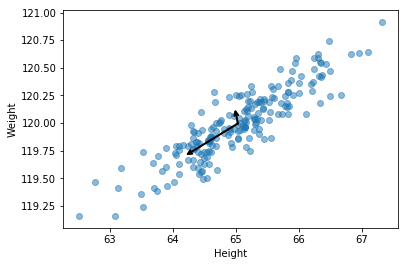

In [4]:
"""
Draw a an arrow from point1 to point2.
Takes an input a matplotlib ax object so
you can add to an existing plot
"""
def DrawArrow(point1, point2, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', point2, point1, arrowprops=arrowprops)

# Make arrows start at the mean of each dimension
mean_vals = [np.mean(data["height"]), np.mean(data["weight"])]
point1 = mean_vals

# Draw one earrow for pc1, and pc2, corresponding to the direction (eigvector) of each PC
# Scale each arrow relatively based on eigenvalues
pc1_point2 = mean_vals+pcs[0]*np.sqrt(pc_magnitudes[0])
pc2_point2 = mean_vals+pcs[1]*np.sqrt(pc_magnitudes[1])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data["height"], data["weight"], alpha=0.5);
DrawArrow(point1, pc1_point2, ax=ax)
DrawArrow(point1, pc2_point2, ax=ax)
ax.set_xlabel("Height")
ax.set_ylabel("Weight");

**Question 2 (1 pt)**: Do the directions and magnitude match what you predicted? Do both PCs explain about equal amounts of variation in our data, or is one dominant?

The magnitudes match, the directions are slightly off from what I said. I said that they would be orthogonal and form and "X", but in the graph above they are not. The two PC's say that one PC is a lot more dominant than the other. This makes sense since the magnitude is determined by the maximum spread in that direction. This indicates which PC's are more telling of the data. In this case it is PC 1 (usually the first PC if they are sorted by magnitude).

Now that we have the PCs, we can visualize our data in PC space by "projecting" each point onto the top 2 PCs.  

Below shows how to do this using the `fit_transform` method of `sklearn`.

Note, here we only had 2 dimensions to begin with, so the top two PCs explain all of the variation in our data. So our plot should basically look like a random cloud of data. In future examples with many more dimensions, plotting the highest PCs of our data will help visualize clusters of related samples (see below).

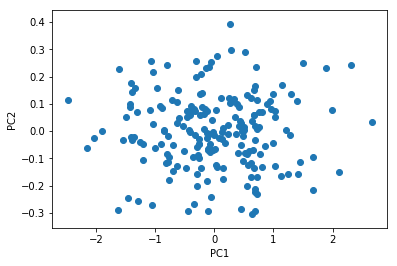

In [5]:
# Project data onto top PCs:

# Using sklearn transform method
data_transformed_sklearn = pca.transform(data[["height","weight"]])

# Compare
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data_transformed_sklearn[:,0], data_transformed_sklearn[:,1])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2");

(**Optional**): To demonstrate what the PCA function is actually doing internally, below is some custom Python code to do the same thing. How well does this compare to the `sklearn` solution?

PC 1 magnitude: 0.00381265750441
PC 1: [ 0.94446029  0.32862557]
PC 2 magnitude: 9.23894775678e-05
PC 2: [-0.32862557  0.94446029]


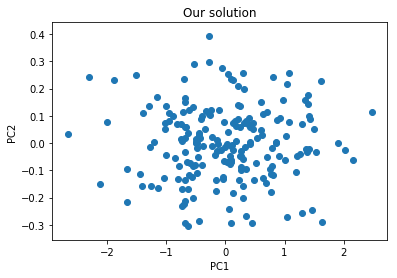

In [6]:
#### This cell implements PCA on our dataset ####
# Center each feature
data["height_cent"] = data["height"]-np.mean(data["height"])
data["weight_cent"] = data["weight"]-np.mean(data["weight"])
# Calculate the covariance matrix
n_samples = data.shape[0]
cov = np.cov(data[["height_cent","weight_cent"]].transpose())/n_samples
# Calculate the eigenvalues and eigenvectors of cov
eigvals, eigvecs = np.linalg.eig(cov)
print("PC 1 magnitude: %s"%eigvals[0])
print("PC 1: %s"%eigvecs.transpose()[0])
print("PC 2 magnitude: %s"%eigvals[1])
print("PC 2: %s"%eigvecs.transpose()[1])

# Transform data using our computed eigvecs
data_transformed = np.array(data[["height_cent","weight_cent"]]).dot(eigvecs)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data_transformed[:,0], data_transformed[:,1])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Our solution");

You should find that the `sklearn` approach matches our implementation above, with perhaps the exception that the direction of one or more eigenvectors is flipped. The eigenvalues are different, but have similar relative magnitude (i.e. PC1 explains much more of the data than PC2).


## 2. Using PCA for clustering and outlier detection 

Now we'll use PCA to explore a bigger, multidimensional dataset. PCA can be very helpful as a data exploration tool, and also to help find things that might be wrong in our data. In this example, we'll look at what happens to PCA when you have "outlier" samples. You should hopefully see that:

* PCA can be a useful tool to *detect* outliers that need to be removed from analysis.
* The clusters you identify using PCA can be dramatically affected by outlier samples.

This example again is on simulated data to allow us to get a feel for how PCA works before moving on to the actual genetics data. <font color="red">This section is completely for data exploration. There are no points associated with this section.</font>

You are given gene expression data for 100 genes in 500 different samples originating from four cell types. The data is stored in the matrix `features` below, which has 500 rows and 100 columns. You're additionally given the vector `labels` which tells you which cell type (0, 1, 2, or 3) your sample belongs to. The cell below simulates this dataset.

In [7]:
## This cell generates simulated data for the exercise. ##

from sklearn.datasets import make_blobs
# Make features and targets with 500 samples,
features, labels = make_blobs(n_samples = 500,
                  # two feature variables,
                  n_features = 100,
                  # four clusters,
                  centers = 4,
                  # with .65 cluster standard deviation,
                  cluster_std = 10,
                  # shuffled,
                  shuffle = True)

# Introduce outlier sample
features[75,:] = np.random.uniform(0, 100000, size=100)
features[51,:] = np.random.uniform(0, 150, size=100)

print(features.shape) # 500 rows, 100 cols of features matrix
print(labels.shape) # 500 nrows 

(500, 100)
(500,)


/opt/conda/lib/python3.6/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(4, 10) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


Now, let's perform PCA on the features matrix and project each sample onto the first two PCs. The cell below performs PCA and makes a scatter plot of PC1 vs. PC2, coloring each data point based on its cell type.

(Note, when doing `ax.scatter` you can pass a list of colors to use for each data point, e.g. `ax.scatter(x, y, color=colors)`). This will be helpful when you need to do your own plotting below!

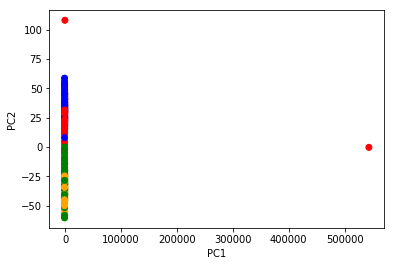

In [8]:
def GetColor(item):
    colors = ["red","orange","green","blue"]
    return colors[item]

pca = sklearn.decomposition.PCA()
pca.fit(features)
transformed_data = pca.transform(features)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(transformed_data[:,0], transformed_data[:,1], color=[GetColor(item) for item in labels])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2");

You'll see that the plot looks kinda of funny! Do you see any samples that may be "outliers"? Outlier samples (for instance that have way more extreme data values than most of the other samples) can severely mess up the results of our PCA. We can eyeball cutoffs for what look like outlier samples and get rid of those:

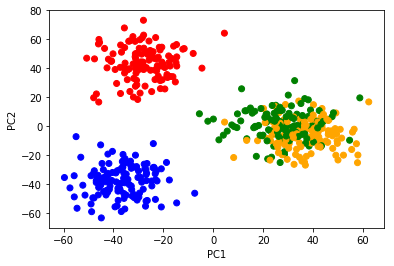

In [9]:
pc1_thresh = 10000
pc2_thresh = 90
outlier_pc1 = [i for i in range(len(transformed_data)) if transformed_data[:,0][i]>pc1_thresh]
outlier_pc2 = [i for i in range(len(transformed_data)) if transformed_data[:,1][i]>pc2_thresh]
outliers = set(outlier_pc1+outlier_pc2)
keep = [i for i in range(features.shape[0]) if i not in outliers]

# Remove outlier indices from features and labels
features_rmoutlier = features[keep,:]
labels_rmoutlier = labels[keep]

# Redo PCA
pca = sklearn.decomposition.PCA()
pca.fit(features_rmoutlier)
transformed_data_rmoutlier = pca.transform(features_rmoutlier)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(transformed_data_rmoutlier[:,0], transformed_data_rmoutlier[:,1], color=[GetColor(item) for item in labels_rmoutlier])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2");

Hopefully you found that after removing outliers, your PCA analysis could successfully distinguish four clusters of cell types.
(Note, the data is randomly generated, so it's possible you'll need to modify the specific thresholds.)

## 3. VCFs and command line wizardry

Now that you have a feel for what PCA is doing, let's apply it to our human genetics dataset. You have performed SNP genotyping on a cohort of individuals consisting of diverse ancestral backgrounds (including African, European, East Asian, and Native American) to use as a reference panel for ancestry analysis. 

First, let's take a look at the data files we have collected in the `week3` directory:

```shell
ls -ltrh /datasets/cs185s-sp19-public/week3
```

You should see:
* `gtdata_1000Genomes.vcf.gz` (1.7G): A VCF file with SNP genotypes for our cohort
* `gtdata_1000Genomes.vcf.gz.tbi` (308K): The VCF index file
* `gtdata_sample_labels.csv`: gives a population label for each of our samples. See  http://www.internationalgenome.org/category/population/ for a description of the codes.

We'll also be using these files in the next sections:
* `friend_genome.vcf.gz` (8.9M): A VCF file with the friend's genome (and it's `.tbi` index). (Downloaded directly from 23andMe)
* `pruned_snps_hg19.bed.gz` (5.3M): A gzipped list of SNP locations we'll be using for PCA (more on this below).

These files will be used on Thursday (ignore for now):
* `gtdata_1000Genomes.ped`, `gtdata_1000Genomes.map`, `gtdata_1000Genomes.fam`: SNP genotypes and height phenotypes for the same set of samples in plink format

It's always a good idea to first do some basic sanity checks and exploration of our data. We'll first review some UNIX commands to get some summary statistics. Later we'll learn how to use `bcftools` to conveniently manipulate VCF files. If you need a refresher on VCF format, remember to look back at the [VCF spec](https://samtools.github.io/hts-specs/VCFv4.2.pdf) as a guide.

Take a look at the top of the VCF file. Since this zipped, you won't be able to use things like `cat` or `head` directly on the file. But you can use the command `zcat` which is like cat but for zipped files.

**Question 3 (1 pt)**: Looking at the header of the VCF file, what was the reference genome assembly used to call these variants? Paste the command you used to look at the file below. Also paste the line of the header where you got your answer. By the way, note this reference is slightly different than hg19, which included "chr1", "chr2", etc. This reference uses "1", "2", etc. (without the "chr"). A common cause of file parsing bugs!

Command run:

zcat /datasets/cs185s-sp19-public/week3/gtdata_1000Genomes.vcf.gz | head

The reference genome is: hs37d5

It comes from the line:

##reference=ftp://ftp.1000genomes.ebi.ac.uk//vol1/ftp/technical/reference/phase2_reference_assembly_sequence/hs37d5.fa.gz

The `tabix` tool provides multiple utilities for making VCF files faster to parse and summarize. Type `tabix` at the command line to see usage. Frequently used commands:

* `tabix -p vcf <myvcf.vcf.gz>` creates an index file `myvcf.vcf.gz.tbi`. This requires your VCF file to be sorted in the first place. Once the index is created, other tools, like `tabix` and `bcftools` can quickly extract important information from VCFs.
* `tabix myvcf.vcf.gz chrom:start-end` will extract only variants (records) from the given genomic region. This can be very useful when you have a huge VCF file and grepping would take forever. This requires the VCF to be indexed.

**Question 4 (1 pt)**: We actually only choose a couple chromosomes to analyze in order to save run time and space (this will be suffficient for our PCA analysis.) Write a one-liner UNIX command to figure out which two chromosomes are included in the VCF. The easiest solution involves `tabix`. Try to figure out from the usage information how to list the chromosomes present. Alternatively, you can pipe together `cut` and `uniq` commands but those will take a while.

tabix /datasets/cs185s-sp19-public/week3/gtdata_1000Genomes.vcf.gz -l

The chromosomes present in the VCF file are 2 and 15.

Scroll down to the first variant entry (2:10179) after the header lines, which all start with a `#`. You might find the command:

```shell
zcat /datasets/cs185s-sp19-public/week3/gtdata_1000Genomes.vcf.gz | less -S 
```

helpful for scrolling. And if you're impatient you can type "ctrl+v" to page down very quickly.

You'll notice a funny looking `rs567117114` number in the third column (`ID`). This is the "dbSNP" identifier for this variant (although this actually happens to be an indel!). dbSNP is a catalog of genetic variation, and is a convenient place to look up things like allele frequencies of a SNP in different populations. For intsance, you can see more info about the first variant here: https://www.ncbi.nlm.nih.gov/snp/rs567117114. In human genetics research, we will often talk about "rsIDs", which refer to dbSNP identifiers.

Use the `tabix` tool to look at data for a specific SNP, rs12913832

```shell
tabix /datasets/cs185s-sp19-public/week3/gtdata_1000Genomes.vcf.gz 15:28365617-28365618 | \
  grep rs12913832 | cut -f 1-9
```

Note in this command:
* `tabix <vcf> <region>` pulls out a specific chromosomal region from a VCF file (rather than having to grep through the whole file which would take a looong time.
* `grep XXX` searches the resulting lines for a pattern, here the rsid
* `cut -f 1-9` shows us the first 9 columns of that line.

**Question 5 (2 pts)**: Take a look at the header to figure out what each of the INFO fields mean. For the variant rs12913832, what population is the alternate allele ("G") most common in? What is the minor allele frequency in European populations? In East Asian populations? In African populations? Which INFO fields did you use to get your answer?

Output of above command:

15      28365618        rs12913832      A       G       100     PASS    AC=888;AF=0.177316;AN=5008;NS=2504;DP=19161;EAS_AF=0.002;AMR_AF=0.2017;AFR_AF=0.028;EUR_AF=0.6362;SAS_AF=0.0706;AA=A|||;VT=SNP   GT

Command run: 

tabix /datasets/cs185s-sp19-public/week3/gtdata_1000Genomes.vcf.gz -H

First few of the field identifiers are #CHROM,  POS,     ID,      REF,     ALT,     QUAL,    FILTER,  INFO,    FORMAT, etc

rs12913832 is in the third field which is the ID.

The reference for this variant is an, A, the alternate or variant is a, G. This variant is most common in the EUR population. 

For the allele frequency in each population the description of the fields are listed below.
##INFO=<ID=EAS_AF,Number=A,Type=Float,Description="Allele frequency in the EAS populations calculated from AC and AN, in the range (0,1)">
##INFO=<ID=EUR_AF,Number=A,Type=Float,Description="Allele frequency in the EUR populations calculated from AC and AN, in the range (0,1)">
##INFO=<ID=AFR_AF,Number=A,Type=Float,Description="Allele frequency in the AFR populations calculated from AC and AN, in the range (0,1)">
##INFO=<ID=AMR_AF,Number=A,Type=Float,Description="Allele frequency in the AMR populations calculated from AC and AN, in the range (0,1)">
##INFO=<ID=SAS_AF,Number=A,Type=Float,Description="Allele frequency in the SAS populations calculated from AC and AN, in the range (0,1)">

Hence the allele frequencies and info fields are as follows: <br>
European populations: 0.6362, EUR_AF <br>
East Asian populations: 0.002, EAS_AF <br>
African populations 0.028, AFR_AF

**Question 6 (1 pt)**: Look up this SNP on [SNPPedia](https://www.snpedia.com/index.php/Rs12913832), a popular site that catalogs different phenotypes linked to different SNPs. What phenotype is strongly linked to this SNP? Does this make sense with the allele frequencies you found above?

The phenotype strongly linked to this SNP is blue eye color. This makes sense in that mostly Europeans exhibit this trait when compared with East Asians and Africans. 

**Question 7 (3 pts)**: Use a one-liner command (you may pipe multiple commands together) to determine (1) how many variants are included in this VCF file and (2) how many samples there are. 

The fastest way to do this is to use tools built specifically to take advantage of the VCF index file to perform computations very quickly on VCF files. `bcftools` provides many utilities for manipulating VCF files. See if you can figure out how to get information about the number of variants and the number of samples using the following commands:

* `bcftools index` has an option to print the number of variants in a VCF file. (hint, a "record" means "variant")
* `bcftools query` has an option to list the samples in a VCF file. You can pipe this to another command (for instance, involving `wc`) to count the number of samples.

Type of each these commands at the terminal to see basic usage.

You could also pipe together a solution involving `zcat`, `grep`, and `awk`. But that will take much longer.

For number of variants (records): 9506289 variants<br>
Command:  bcftools index -n /datasets/cs185s-sp19-public/week3/gtdata_1000Genomes.vcf.gz

For number of samples: 2504<br>
Command: bcftools query -l /datasets/cs185s-sp19-public/week3/gtdata_1000Genomes.vcf.gz | wc -l

Finally, let's introduce one more very useful command feature of `bcftools query` for manipulating VCF files. VCF files can be a little overwhelming to look at by themselves, especially one like this that contains hundreds or thousands of samples with many differnt INFO fields. You can use `bcftools query` to output only the desired fields in a customizable format. For instance:

```
bcftools query -f "%CHROM\t%POS[\t%SAMPLE=%GT]\n" /datasets/cs185s-sp19-public/week3/gtdata_1000Genomes.vcf.gz
```

will print out only the chromosome, position, and genotype of each sample (give it a try, you might want to pipe to `less -S` to scroll horizontally through the output).

**Question 8 (1 pt)**: Modify the `bcftools query` command above to output only results for samples HG01188 and HG01066 in the region 15:28365617-28365618 and to additionally output the rsID (or esvID, which is for structural variants rather than SNPs) for each variant. (type `bcftools query` or google to find out the options that will allow you to do this). Paste the command and output below.

bcftools query /datasets/cs185s-sp19-public/week3/gtdata_1000Genomes.vcf.gz -s HG01188,HG01066 -r 15:28365617-28365618 -f '%CHROM %POS %ID %REF %ALT [%SAMPLE=%GT ]\n'

15 28343591 esv3635988 G <CN2> HG01188=0|0 HG01066=0|0 <br>
15 28353161 esv3635989;esv3635990 G <CN0>,<CN2> HG01188=0|0 HG01066=0|0 <br>
15 28365618 rs12913832 A G HG01188=0|0 HG01066=0|0

## 4. Preprocessing our data for PCA

Now that we're more familiar with VCF files, let's get ready to perform PCA based on the SNP genotypes of our samples. First, let's learn a little bit more about the population groups in our datasets. Look at the file `gtdata_sample_labels.csv` in the `week3` datasets directory. You'll see each sample has been assigned a three letter code. This corresponds to population labels used as part of the 1000 Genomes Project: http://www.internationalgenome.org/category/population/.

You can use the `uniq -c` command to see how many samples we have in each group:
```
cat /datasets/cs185s-sp19-public/week3/gtdata_sample_labels.csv | cut -f 2 -d',' | sort | uniq -c
```

To perform PCA, we'll first want to "prune" our variants to get variants that are relatively independent and remove rare variants that might be potential outliers in our analysis. There is a little bit of art to doing this, so instead for today we have provided you a good list of SNPs to use:

```
/datasets/cs185s-sp19-public/week3/pruned_snps_hg19.bed.gz
```

This is a BED file, a common format in genomics analyses. BED files simply store regions, or "chunks" of the genome, with one chunk per line. In our case, the BED file contains a list of positions we will want to extract from our dataset. There are 3 main columns: chromosome, start, end and position. Do `zcat` on the file to take a look. BED files can sometimes have other score or strand information, but we won't use the extra columns here (see [bed file format](https://genome.ucsc.edu/FAQ/FAQformat.html#format1)).

**Question 9 (4 pts)**: Use `bcftools view` to extract a list these regions from the VCF file `gtdata_1000Genomes.vcf.gz`. How many variants remain in your pruned VCF file (it should be way fewer than the original file. close to 100,000)?

See the usage for how to use the following options:
* Input a file containing a list of regions (this can be our `pruned_snps_hg19.bed.gz` above.
* Output the VCF in gzipped format.
* Output the new VCF file to `~/week3/gtdata_1000Genomes_pruned.vcf.gz`
* Output only SNPs.

After you have generated the pruned VCF file, use `tabix` to index it (`tabix -p vcf ~/week3/gtdata_1000Genomes_pruned.vcf.gz`)

Paste the commands you used and your answer below.

<font color="red">This will take a couple minutes (or possibly more). If this is taking too long, you can copy the precomputed result from `/datasets/cs185s-sp19-public/week3/precomputed/`. But you still need to put the commands you would use, and the number of variants in the new file, below. </font>

bcftools view /datasets/cs185s-sp19-public/week3/gtdata_1000Genomes.vcf.gz -v snps -R /datasets/cs185s-sp19-public/week3/pruned_snps_hg19.bed.gz -O z -o ~/week3/gtdata_1000Genomes_pruned.vcf.gz

tabix -p vcf ~/week3/gtdata_1000Genomes_pruned.vcf.gz

For number of variants (records): 103711 variants

Command: bcftools index -n ~/week3/gtdata_1000Genomes_pruned.vcf.gz

For number of variants (records): 103711 variants

Command: bcftools index -n /datasets/cs185s-sp19-public/week3/precomputed/gtdata_1000Genomes_pruned.vcf.gz

Now, let's get ready to perform PCA. Recall from our example that PCA will need to take in a matrix of data. Here, our matrix consists of a set of samples (columns) and genotypes (rows) for each SNP. Later, in Python, we'll transpose this matrix to the format we need for PCA (SNPs=columns, samples=rows). As we discussed in the prelab, we can conveniently represent almost all SNP genotypes as "0" (homozygous reference), "1" (heterozygous), or "2" (homozygous non-reference). We'll also want to include column headers so we know which column belongs to which sample.

(**Note**: we give a suggested way to make this matrix below with `bcftools`. But if you have a different way you're welcome to use that too!)

We can use `bcftools` query to easily extract genotypes from our file. For example, the command below will output the "GT" field of each of our samples. Give it a try (probably want to pipe to `head` or `less -S`!

```shell
bcftools query -f "[%GT\t]\n" ~/week3/gtdata_1000Genomes_pruned.vcf.gz
```

This isn't quite what we need yet, genotypes are represented as "0|0", "0|1", etc. rather than as single numbers (0, 1, 2). (If we pass these strings to our PCA it will just explode.).

For this, we will use a new command, `sed`. This command can be used for many text manipulations, but one of the most common use cases as a "find and replace" tool. The general syntax is:

```
sed 's/<find>/<replace>/g' file.txt # OR
cat file.txt | sed 's/<find>/<replace>/g'
```
For example:
```
cat file.txt | sed 's/0|0/0/g'
```
replaces all instances of the string "0|0" in the file `file.txt` with just "0". Note if you leave off the last `g` (e.g. `sed 's/0|0/0/`, the command will only replace the first instance it finds on each line. Using `g` makes it replace all instances.

The following replaces genotypes with the appropriate number:

```shell
bcftools query -f "[%GT\t]\n" ~/week3/gtdata_1000Genomes_pruned.vcf.gz | 
    sed 's/0|0/0/g' | sed 's/0|1/1/g' | sed 's/1|0/1/g' | sed 's/1|1/2/g'
```

There will be a couple of problematic genotypes that won't be converted correctly. So we'll add a couple `sed` commands to clean these up (this is advanced `sed` syntax you won't need to know for a quiz, but necessary to get our code to work!)
* `sed s/[[:space:]]*$//'` will get rid of trailing whitespace output from `bcftools query`
* `sed 's/\//|/g'` will replace a few problematic genotypes with "/" rather than "|" separating the two alleles of the genotype.
* `grep -v "|"` at the end gets rid of lines with any genotypes that couldn't be converted to numerical format for some reason (for instance, they had more than 2 alleles).

Putting these together we get:
```shell
bcftools query -l ~/week3/gtdata_1000Genomes_pruned.vcf.gz | datamash transpose > ~/week3/gtdata_matrix.tab
bcftools query -f "[%GT\t]\n" ~/week3/gtdata_1000Genomes_pruned.vcf.gz | sed 's/[[:space:]]*$//' | \
    sed 's/\//|/g' | \
    sed 's/0|0/0/g' | sed 's/0|1/1/g' | sed 's/1|0/1/g' | sed 's/1|1/2/g'| \
    grep -v "|"  >> ~/week3/gtdata_matrix.tab
```

Note, the first command prints a header line (all the sample names). The second command **appends** (using `>>` rather than `>`) to that file by writing the genotypes (after removing trailing whitespace and converting genotypes to 0,1,2 format and getting rid of any lines containing genotypes that are not 0|0, 1|0, 0|1, or 1|1). 

After the command completes, use `less -S ~/week3/gtdata_matrix.tab` to inspect the file. You should see a matrix of 0s, 1s, and 2s with a header file giving sample names.

## 5. Running PCA

The code below loads this dataset, setting `samples` to a list of sample names and `gtdata` as a 2d array of the genotype data, with rows=samples and columns=variants:

In [1]:
%pylab inline
import pandas as pd
import sklearn.decomposition
import os

data = pd.read_csv(os.path.join(os.environ["HOME"], "week3", "gtdata_matrix.tab"), sep="\t").transpose()
samples = [item.split("_")[0] for item in list(data.index)] # list of sample names
gtdata = np.array(data) # matrix of genotypes

# Check summary data
print("Number of samples: %s"%gtdata.shape[0])
print("Number of variants: %s"%gtdata.shape[1])

Populating the interactive namespace from numpy and matplotlib
Number of samples: 2504
Number of variants: 103096


**Question 10 (12 pts)**: Perform PCA on the matrix of genotypes. Plot the samples projected onto the first two principal components. Color samples by super population (red=AFR, gold=EUR, green=EAS, blue=SAS, purple=AMR). Be sure to label the axes!

Note for that you'll have to also figure out how to load the population labels and convert each population label to a superpopulation using the definitions here: http://www.internationalgenome.org/category/population/. We've written some example code to get you started with that.

We recommend you use Python (`sklearn`) for this, drawing on the code above to see how to run PCA and do the plotting. But you can also use whatever language or command line tool you want as long as the plot is included inline below and you tell us what commands you used! 

<font color="red">Hint: the PCA can take a long time, especially if you use Python. For debugging, it can be helpful to run your plotting in a separate cell to test that without having to rerun PCA each time. You can also run PCA on a much smaller set of SNPs by taking only a subset of columns to test first. The example line below to create `gtdata_sub` shows how to do this.</font>

In [22]:
# Load sample data

# Recommend to subset the SNPs so PCA doesn't take so long. Can remove to run on
# all data. May not be necessary to get a good PCA
# gtdata[:,0:n] subsets to the first n SNPs
# Try testing on ~1,000 first to see if your code works
gtdata_sub = gtdata[:,0:3000]

# sample_to_pop[sample] = population
sample_to_pop = {}
with open("/datasets/cs185s-sp19-public/week3/gtdata_sample_labels.csv") as f:
    for line in f:
        s, pop = line.strip().split(",")
        sample_to_pop[s] = pop

# Suggested colors for each population
def GetColor(pop):
    if pop in ["CHB","JPT","CHS","CDX","KHV"]: return "green"
    if pop in ["CEU","TSI","FIN","GBR","IBS"]: return "gold"
    if pop in ["YRI","LWK","GWD","MSL","ESN","ASW","ACB"]: return "red"
    if pop in ["MXL","PUR","CLM","PEL"]: return "purple"
    if pop in ["GIH","PJL","BEB","STU","ITU"]: return "blue"
    return "gray"

# Perform PCA and plot PC1 vs. PC2 of your data below
pca = sklearn.decomposition.PCA()
pca.fit(gtdata_sub)
gtdata_trans = pca.transform(gtdata_sub)

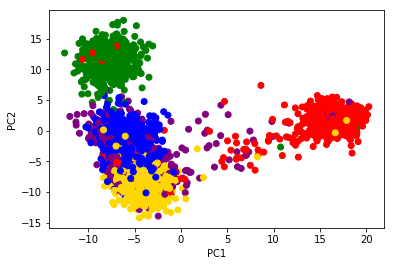

In [23]:
colors = [GetColor(sample_to_pop[item]) for item in sample_to_pop]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(gtdata_trans[:,0], gtdata_trans[:,1], color = colors)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2");

**Question 11 (1 pt)**: If your analysis worked, you should see what kind of looks like a triangle. What super-populations do the clusters at the three points of the triangle represent?

The three superslusters that we see representing the three corners of the triangle are African, East Asian and European (red, green and gold).

**Question 12 (1 pt)**: Which groups of superpopulations are separated by the first PC (i.e. direction explaining most of the variation in our data). What about the second PC?

The first PC separates the superpopulations of Asian and European from African. The second PC then separates the Asian and European superpopulations.

**Question 13 (2 pts)**: Now plot PC2 vs. PC3. What populations are separated by the 3rd PC? Include your code and answer (as a comment) in the cell below.

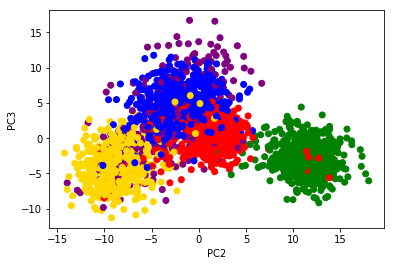

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(gtdata_trans[:,1], gtdata_trans[:,2], color = colors)
ax.set_xlabel("PC2")
ax.set_ylabel("PC3");

The second PC as we said earlier separates the European and East Asian superpopulations. Adding the third PC shows that it separates the South Asian (blue) from those of the European and East Asian populations (gold and green).

# 5. Determining the ancestry of new samples

Now, we'll use our labeled reference panel to infer the ancestry of a new genome. As a test case, we have included the friend's genome (downloaded directly from 23andme! which may or may not be from one of the instructors...) at `/datasets/cs185s-sp19-public/week3/friend_genome.vcf.gz`.

**Question 14 (3 pts)**: First, since our analysis is for only two chromosomes, let's subset the VCF to only include those chromosomes. Write a command to do this and output the new (bgzipped) file to `~/week3/friend_genome_subset.vcf.gz`. Paste your command below (there are multiple ways to do this).

Hint: the easiest way to do this is with `bcftools view`. It can take a list of regions. In our case, our "regions" are chromosomes. So you could add option `bcftools view -r 2,15 ...`

Other notes (useful if you decide not to use `bcftools`. although not recommended!):
* you can zip a VCF file by piping to `bgzip` using: `cat myfile.vcf | bgzip -c > myfile.vcf.gz`. You can also first write a non-zipped VCF and use `bgzip myfile.txt` to zip it.
* If you use `grep`, make sure you don't get rid of the VCF header!
* Watch out that `grep 1` would also give things like 11, 12, 13, etc.
* You can use `grep "pattern1\|pattern2\|pattern3"` to find lines matching any of the three patterns

bcftools view -r 2,15 /datasets/cs185s-sp19-public/week3/friend_genome.vcf.gz -v snps -O z -o ~/week3/friend_genome_subset.vcf.gz

We don't need the following commands below since we are merging with other vcf file:

tabix -p vcf ~/week3/friend_genome_subset.vcf.gz

bcftools index -n ~/week3/friend_genome_subset.vcf.gz

./preprocess_23andme.sh \
  ~/week3/friend_genome_subset.vcf.gz \
  ~/week3/gtdata_1000Genomes_pruned.vcf.gz

The easiest way to determine the ancestry of the new genome is to make a new VCF file including that sample in our PCA analysis. You can use the following command to merge the 23andme genome and the reference panel VCF:

```shell
./preprocess_23andme.sh \
  ~/week3/friend_genome_subset.vcf.gz \
  ~/week3/gtdata_1000Genomes_pruned.vcf.gz
```

This should output a new merged VCF file at `~/week3/gtdata_merged.vcf.gz `

**Optional** You are welcome to take a look at the script `./preprocess_23andme.sh`, which performs some necessary cleanup and merges the VCF files. This may look like a lot, and gets into the gory (and sometimes ugly) details of inconsistent annotation across VCF files. It also uses `plink`, which we will officially introduce on Thursday. The script deals with some of these issues (and we're happy to answer questions about why these steps are necessary).
* The 23andMe VCF file has some alleles listed as lower case which need to be converted to upper case.
* The 23andMe VCF file is missing some variant, has some extra variants, and for some it has the reference vs. alternate allele flipped.

**Question 15 (5 pts)**: Rerun PCA analysis using the merged VCF file `~/week3/merged.vcf.gz`, using similar steps to what we did above. Include any commands and your plot of PC1 vs. PC2 below. Label the unknown genome with a different color. You may include multiple cells (e.g. one with shell commands and another with python to generate the plot).

Hint: it might be hard to see the unknown point (which should be a gray or other different color). You can make the dots smaller with the `s` option to scatter, and do a separate scatter command with only the new point with a larger dot size to make it more visible.

Hint: Like above, if you are having trouble, it is always a good idea to debug your code using a smaller example (e.g. by subsetting SNPs) to make sure the code is working before running on everything.

bcftools query -l ~/week3/gtdata_merged.vcf.gz | datamash transpose > ~/week3/gtdata_matrix_merged.tab

bcftools query -f "[%GT\t]\n" ~/week3/gtdata_merged.vcf.gz | sed 's/[[:space:]]*$//' | \
    sed 's/\//|/g' | \
    sed 's/0|0/0/g' | sed 's/0|1/1/g' | sed 's/1|0/1/g' | sed 's/1|1/2/g'| \
    grep -v "|"  >> ~/week3/gtdata_matrix_merged.tab

In [25]:
data = pd.read_csv(os.path.join(os.environ["HOME"], "week3", "gtdata_matrix_merged.tab"), sep="\t").transpose()
samples = [item.split("_")[0] for item in list(data.index)] # list of sample names
gtdata = np.array(data) # matrix of genotypes

# Check summary data
print("Number of samples: %s"%gtdata.shape[0])
print("Number of variants: %s"%gtdata.shape[1])

Number of samples: 2505
Number of variants: 51458


In [26]:
gtdata_sub = gtdata[:,0:3000]
pca = sklearn.decomposition.PCA()
pca.fit(gtdata_sub)
gtdata_trans = pca.transform(gtdata_sub)

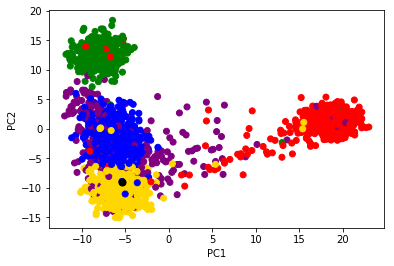

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(gtdata_trans[:,0][1::], gtdata_trans[:,1][1::], color = colors)
ax.scatter(gtdata_trans[:,0][0:1], gtdata_trans[:,1][0:1], s=50, color="black")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2");

**Question 16 (1 pt)**: What is the ancestry (superpopulation is good enough) of the new sample?

We can see that the new sample falls into the gold region of the PC plot. This corresponds to European ancestry.

## Optional (on your own)

If you have done 23andMe, you're welcome to try this out on your own genome! You just need to download the VCF file available once you're logged in and repeat the steps above using that VCF file. Please don't turn in your answer, this is for fun and for your own curiosity. You will not receive any points for doing this.